## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Input, Dense
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation='relu', name='hidden_layer%d'%(i+1))(x)
            x = BatchNormalization()(x)
        
    output_layer = Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [6]:
# hyperparams
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024

In [8]:
# save_best_only = False
model_ckpt1 = keras.callbacks.ModelCheckpoint(filepath = './tmp.h5',
                                            monitor = 'val_loss',
                                            save_best_only = False)

results = {}

keras.backend.clear_session()
print('Experiment with save_best_only = False')

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         shuffle=True,
         callbacks=[model_ckpt1])

results['not-saved'] = {'train_loss': model.history.history['loss'],
                       'valid_loss': model.history.history['val_loss'],
                       'train_acc': model.history.history['accuracy'],
                       'valid_acc': model.history.history['val_accuracy']}

Experiment with save_best_only = False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_

Epoch 44/50
50000/50000 [==============================] - 35s 698us/step - loss: 0.1531 - accuracy: 0.9531 - val_loss: 3.0028 - val_accuracy: 0.4554
Epoch 45/50
50000/50000 [==============================] - 35s 706us/step - loss: 0.1443 - accuracy: 0.9555 - val_loss: 3.1457 - val_accuracy: 0.4392
Epoch 46/50
50000/50000 [==============================] - 34s 687us/step - loss: 0.1350 - accuracy: 0.9591 - val_loss: 2.9847 - val_accuracy: 0.4659
Epoch 47/50
50000/50000 [==============================] - 35s 693us/step - loss: 0.1323 - accuracy: 0.9590 - val_loss: 3.1482 - val_accuracy: 0.4342
Epoch 48/50
50000/50000 [==============================] - 35s 699us/step - loss: 0.1300 - accuracy: 0.9607 - val_loss: 3.0293 - val_accuracy: 0.4465
Epoch 49/50
50000/50000 [==============================] - 34s 689us/step - loss: 0.1205 - accuracy: 0.9637 - val_loss: 3.1649 - val_accuracy: 0.4623
Epoch 50/50
50000/50000 [==============================] - 35s 694us/step - loss: 0.1116 - accuracy:

In [10]:
# 載入 Callbacks
model_ckpt2 = keras.callbacks.ModelCheckpoint(filepath = './tmp2.h5',
                                            monitor = 'val_loss',
                                            save_best_only = True)

keras.backend.clear_session()
print('Experiment with save_best_only = True')

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         validation_data=(x_test, y_test),
         shuffle=True,
         callbacks=[model_ckpt2])

results['saved'] = {'train_loss': model.history.history['loss'],
                       'valid_loss': model.history.history['val_loss'],
                       'train_acc': model.history.history['accuracy'],
                       'valid_acc': model.history.history['val_accuracy']}

Experiment with save_best_only = True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3

50000/50000 [==============================] - 35s 695us/step - loss: 0.1439 - accuracy: 0.9560 - val_loss: 2.7799 - val_accuracy: 0.4743
Epoch 46/50
50000/50000 [==============================] - 35s 692us/step - loss: 0.1329 - accuracy: 0.9597 - val_loss: 2.9934 - val_accuracy: 0.4630
Epoch 47/50
50000/50000 [==============================] - 35s 690us/step - loss: 0.1295 - accuracy: 0.9610 - val_loss: 3.0898 - val_accuracy: 0.4584
Epoch 48/50
50000/50000 [==============================] - 34s 687us/step - loss: 0.1328 - accuracy: 0.9592 - val_loss: 3.2143 - val_accuracy: 0.4389
Epoch 49/50
50000/50000 [==============================] - 35s 705us/step - loss: 0.1263 - accuracy: 0.9618 - val_loss: 3.0438 - val_accuracy: 0.4631
Epoch 50/50
50000/50000 [==============================] - 34s 688us/step - loss: 0.1213 - accuracy: 0.9628 - val_loss: 3.3030 - val_accuracy: 0.4449


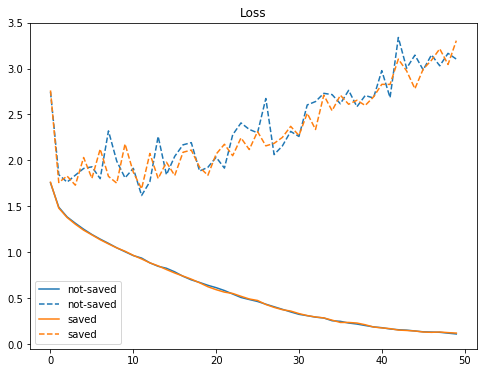

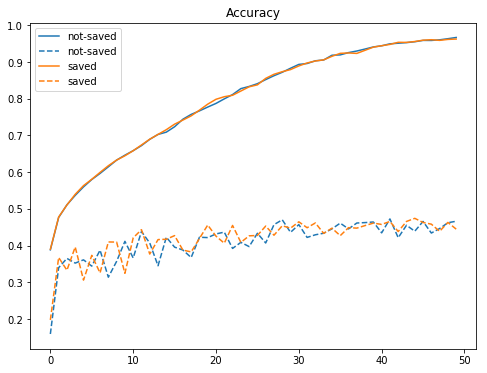

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['C0', 'C1']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
plt.legend()
plt.show()

###  reset ipynb 並將模型與權重重新建回並預測 x_test

In [13]:
import keras
model = keras.models.load_model('./tmp2.h5')
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 520us/step


In [14]:
loss_loadback

1.6905413675308227

In [15]:
acc_loadback

0.44339999556541443